In [1]:
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install medmnist
clear_output()

In [3]:
from resnet import ResNet50
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import classification_report
import pickle
import matplotlib.pyplot as plt
from medmnist import dataset
import numpy as np
import torchvision.transforms as transforms
import random
import os

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [5]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256
EPOCHS = 10
img_size = 28
lr = 0.001

model_store_path = "/content/drive/MyDrive/DLAM/DLAM-Project/models/"

In [6]:
train_dataloader = torch.utils.data.DataLoader(
    dataset.OrganAMNIST(
        # root=data_dir,
        split='train',
        transform=transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ]),
        target_transform=transforms.Lambda(lambda x: x[0]),
        # flag=dataset_name,
        download=True
    ),
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset.OrganAMNIST(
        # root=data_dir,
        split='test',
        transform=transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ]),
        target_transform=transforms.Lambda(lambda x: x[0]),
        # flag=dataset_name,
        download=True
    ),
    batch_size=batch_size,
    shuffle=False
)

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz


In [7]:
num_classes = len(train_dataloader.dataset.info["label"])
classes = list(train_dataloader.dataset.info["label"])
model = ResNet50(num_classes=num_classes, channels=1).to(device)

In [8]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, last_epoch=-1, verbose=False)


In [9]:
def training(dataloader, device, model, criterion, scheduler):
    model.train()
    losses = []
    running_loss = 0

    pbar = tqdm(dataloader, unit="batch", desc="Training")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.view(-1).to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = sum(losses)/len(losses)
    scheduler.step()

    return model, scheduler, avg_loss

def classify_dataloader(dataloader, device, model):
    model.eval()
    y_pred = []
    y_true = []
    losses = []
    running_loss = 0
    pbar = tqdm(dataloader, unit="batch", desc="Evaluating")

    with torch.no_grad():

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.view(-1).to(device)
            optimizer.zero_grad()

            outputs = model(inputs)

            labels_predicted = outputs.argmax(1)
            for prediction, label in zip(labels_predicted, labels):
                y_pred.append(int(prediction))
                y_true.append(int(label))

            loss = criterion(outputs, labels)
            losses.append(loss.item())

            running_loss += loss.item()

    avg_loss = sum(losses)/len(losses)
    return y_true, y_pred, avg_loss

In [10]:
losses = {"train_loss": [],
          "test_loss": [],
          "test_predictions": [],
          "model_path": [],
          "test_true_labels": []}

for epoch in range(1, EPOCHS+1):
    print(f"Processing epoch {epoch}:")
    model, scheduler, avg_loss_train = training(train_dataloader, device, model, criterion, scheduler)
    print(f"Avg train loss: {round(avg_loss_train, 3)}")

    y_true, y_pred, avg_loss_test = classify_dataloader(test_dataloader, device, model)
    losses["train_loss"].append(avg_loss_train)
    print(f"Avg test loss: {round(avg_loss_test, 3)}")

    losses["test_loss"].append(avg_loss_test)
    losses["test_predictions"].append([y_pred])
    losses["test_true_labels"].append([y_true])

    losses["model_path"].append(f"{model_store_path}ResNet50original_epoch_{epoch}")

    torch.save(model, f"{model_store_path}ResNet50original_epoch_{epoch}")
    # Save the losses dictionary
    with open(f"{model_store_path}losses.pkl", "wb") as f:
        pickle.dump(losses, f)
    print("\n"*2)

print('Training Done')

Processing epoch 1:


Training: 100%|██████████| 136/136 [00:14<00:00,  9.53batch/s]


Avg train loss: 0.441


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.36batch/s]


Avg test loss: 0.717



Processing epoch 2:


Training: 100%|██████████| 136/136 [00:11<00:00, 12.15batch/s]


Avg train loss: 0.113


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.34batch/s]


Avg test loss: 0.543



Processing epoch 3:


Training: 100%|██████████| 136/136 [00:11<00:00, 12.23batch/s]


Avg train loss: 0.062


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.57batch/s]


Avg test loss: 1.419



Processing epoch 4:


Training: 100%|██████████| 136/136 [00:11<00:00, 12.02batch/s]


Avg train loss: 0.158


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.61batch/s]


Avg test loss: 0.56



Processing epoch 5:


Training: 100%|██████████| 136/136 [00:11<00:00, 12.24batch/s]


Avg train loss: 0.072


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.44batch/s]


Avg test loss: 0.536



Processing epoch 6:


Training: 100%|██████████| 136/136 [00:11<00:00, 11.99batch/s]


Avg train loss: 0.01


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.64batch/s]


Avg test loss: 0.563



Processing epoch 7:


Training: 100%|██████████| 136/136 [00:11<00:00, 12.17batch/s]


Avg train loss: 0.02


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.25batch/s]


Avg test loss: 0.499



Processing epoch 8:


Training: 100%|██████████| 136/136 [00:11<00:00, 12.01batch/s]


Avg train loss: 0.003


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.61batch/s]


Avg test loss: 0.525



Processing epoch 9:


Training: 100%|██████████| 136/136 [00:11<00:00, 12.13batch/s]


Avg train loss: 0.002


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.70batch/s]


Avg test loss: 0.517



Processing epoch 10:


Training: 100%|██████████| 136/136 [00:11<00:00, 12.19batch/s]


Avg train loss: 0.037


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.51batch/s]


Avg test loss: 0.538



Training Done


In [14]:
file = open(f"{model_store_path}losses.pkl", "rb")
losses = pickle.load(file)

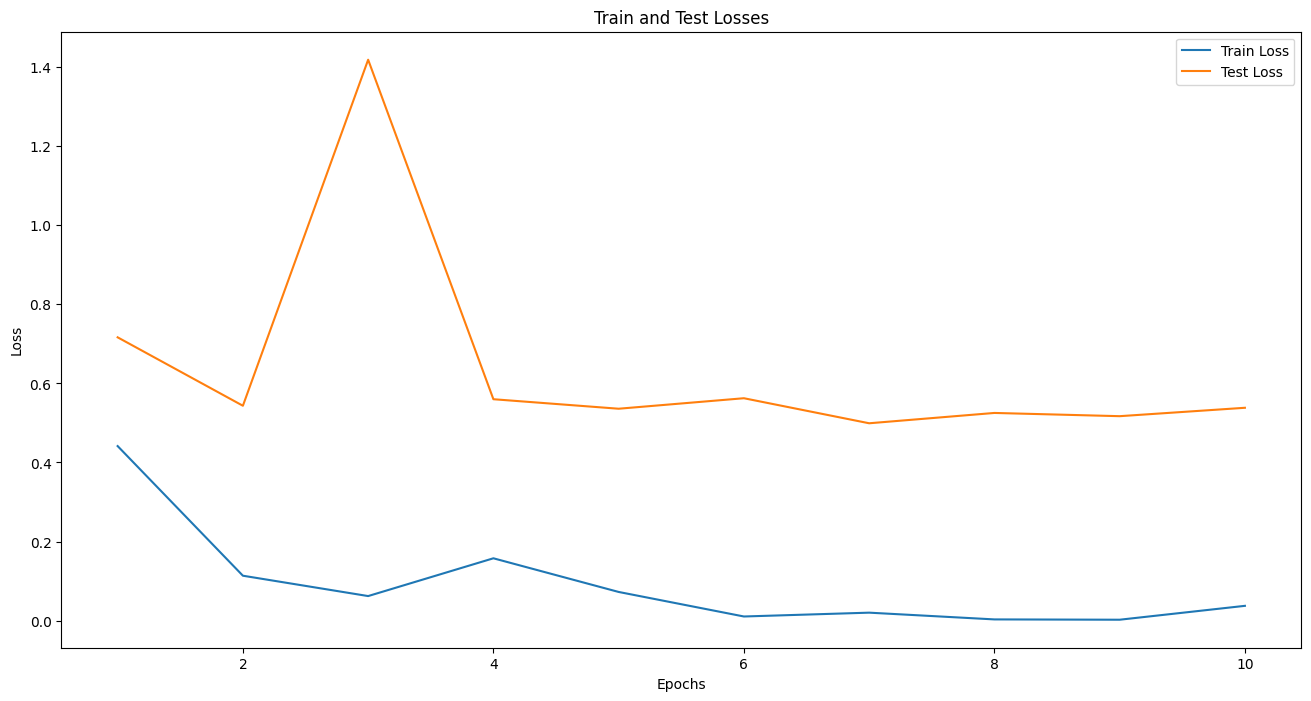

In [36]:
# Create x-axis values (epochs)
epochs = range(1, len(losses['train_loss']) + 1)

# Set the figure size
plt.figure(figsize=(16, 8))
# Plot train and test losses
plt.plot(epochs, losses['train_loss'], label='Train Loss')
plt.plot(epochs, losses['test_loss'], label='Test Loss')


# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()

# Show the plot
plt.show()

In [35]:
y_pred_min = losses["test_predictions"][np.argmin(losses["test_loss"])][0]
y_true_min = losses["test_true_labels"][np.argmin(losses["test_loss"])][0]

report = classification_report(y_true_min, y_pred_min)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1036
           1       0.90      0.90      0.90       784
           2       0.92      0.87      0.90       793
           3       1.00      0.81      0.89       785
           4       0.70      0.77      0.74      2064
           5       0.84      0.85      0.85      1965
           6       0.96      0.97      0.97      3285
           7       0.99      0.97      0.98      1747
           8       0.99      0.96      0.97      1813
           9       0.88      0.86      0.87      1622
          10       0.83      0.85      0.84      1884

    accuracy                           0.89     17778
   macro avg       0.90      0.88      0.89     17778
weighted avg       0.89      0.89      0.89     17778

